# 🛡️ Notebook 04B: Baseline LIMPO (SEM Data Leakage)

**Objetivo:** Corrigir data leakage crítico descoberto no NB04 removendo features `msg6_count` e `msg6_rate` que vazavam definição do target.

**Problema NB04:** Precision 100%, Recall 85.71%, AUC 0.9994 eram **artificiais**. Target `is_critical_target` é definido por `msg6_count > threshold_IQR`, então modelo aprendeu regra circular `if msg6_rate > X: predict critical`. Evidências: msg6_rate 42.1% feature importance (dominante), correlação 0.69 vs target, AUC 0.9994 perfeito suspeito, train AUC 1.0 overfitting.

**Correção aplicada:** Remover todas features msg6/msg_type_6. Modelo aprenderá de padrões legítimos (telemetrias, status, anomalias). Métricas caíram mas são **honestas** e **confiáveis** para produção. Expectativa realista: Recall 20-40%, Precision 50-70%, AUC 0.70-0.85.

**Mensagem-chave:** Métricas caíram porque corrigimos leakage. Resultado agora é realista e válido.

---

## 1️⃣ Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    precision_score,
    f1_score,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from scipy.stats import binomtest

print("✅ Imports completos")

✅ Imports completos


## 2️⃣ Carregar Dados Stratificados

In [2]:
data_dir = Path('../data')
df_train = pd.read_csv(data_dir / 'device_features_train_stratified.csv')
df_test = pd.read_csv(data_dir / 'device_features_test_stratified.csv')

print(f"✅ Train: {df_train.shape[0]} devices, {df_train.shape[1]} colunas")
print(f"✅ Test: {df_test.shape[0]} devices, {df_test.shape[1]} colunas")
print(f"\n📊 Critical devices (is_critical_target):")
print(f"  Train: {df_train['is_critical_target'].sum()}")
print(f"  Test: {df_test['is_critical_target'].sum()}")

✅ Train: 552 devices, 35 colunas
✅ Test: 237 devices, 35 colunas

📊 Critical devices (is_critical_target):
  Train: 31
  Test: 14


## 3️⃣ CRÍTICO: Identificar e Remover Features com Leakage

In [3]:
print("="*70)
print("🔍 IDENTIFICAÇÃO DE FEATURES COM DATA LEAKAGE")
print("="*70)

# Listar TODAS features disponíveis
all_cols = df_train.columns.tolist()
print(f"\n📋 Total de colunas no CSV: {len(all_cols)}")

# Features base a excluir (device_id, targets)
exclude_base = ['device_id', 'is_critical', 'is_critical_target', 'severity_category']

# Features com LEAKAGE (definem ou derivam do target)
leakage_keywords = ['msg6', 'msg_type_6', 'message_type_6']
exclude_leakage = []

for col in all_cols:
    for keyword in leakage_keywords:
        if keyword.lower() in col.lower():
            exclude_leakage.append(col)
            break

print(f"\n🚨 FEATURES COM LEAKAGE IDENTIFICADAS ({len(exclude_leakage)} total):")
for feat in exclude_leakage:
    print(f"  ❌ {feat}")

# Combinar exclusões
exclude_cols = list(set(exclude_base + exclude_leakage))
feature_cols = [col for col in all_cols if col not in exclude_cols]

print(f"\n✅ FEATURES LIMPAS RESTANTES ({len(feature_cols)} total):")
for i, feat in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {feat}")

print(f"\n📊 RESUMO:")
print(f"  Total colunas: {len(all_cols)}")
print(f"  Excluídas (base): {len(exclude_base)}")
print(f"  Excluídas (leakage): {len(exclude_leakage)}")
print(f"  Features finais: {len(feature_cols)}")
print("="*70)

🔍 IDENTIFICAÇÃO DE FEATURES COM DATA LEAKAGE

📋 Total de colunas no CSV: 35

🚨 FEATURES COM LEAKAGE IDENTIFICADAS (2 total):
  ❌ msg6_count
  ❌ msg6_rate

✅ FEATURES LIMPAS RESTANTES (29 total):
   1. total_messages
   2. max_frame_count
   3. optical_mean
   4. optical_std
   5. optical_min
   6. optical_max
   7. optical_readings
   8. optical_below_threshold
   9. optical_range
  10. temp_mean
  11. temp_std
  12. temp_min
  13. temp_max
  14. temp_above_threshold
  15. temp_range
  16. battery_mean
  17. battery_std
  18. battery_min
  19. battery_max
  20. battery_below_threshold
  21. snr_mean
  22. snr_std
  23. snr_min
  24. rsrp_mean
  25. rsrp_std
  26. rsrp_min
  27. rsrq_mean
  28. rsrq_std
  29. rsrq_min

📊 RESUMO:
  Total colunas: 35
  Excluídas (base): 4
  Excluídas (leakage): 2
  Features finais: 29


## 4️⃣ Preparar Features COM IMPUTATION (Preservando Samples)

In [4]:
# Separar X e y ANTES de imputation
X_train = df_train[feature_cols]
y_train = df_train['is_critical_target']

X_test = df_test[feature_cols]
y_test = df_test['is_critical_target']

print(f"📊 ANTES da imputation:")
print(f"  Train: {X_train.shape[0]} devices, {y_train.sum()} critical")
print(f"  Test: {X_test.shape[0]} devices, {y_test.sum()} critical")
print(f"  Missing values no train: {X_train.isnull().sum().sum()}")
print(f"  Missing values no test: {X_test.isnull().sum().sum()}")

# IMPUTATION com estratégia median
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Converter de volta para DataFrame
X_train_imputed = pd.DataFrame(X_train_imputed, columns=feature_cols)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=feature_cols)

print(f"\n✅ IMPUTATION completa!")
print(f"\n📊 DEPOIS da imputation:")
print(f"  Train: {X_train_imputed.shape[0]} devices, {y_train.sum()} critical")
print(f"  Test: {X_test_imputed.shape[0]} devices, {y_test.sum()} critical")
print(f"  Missing values: {X_train_imputed.isnull().sum().sum()} (train), {X_test_imputed.isnull().sum().sum()} (test)")
print(f"\n✅ TODOS os 31 train e 14 test critical preservados!")

📊 ANTES da imputation:
  Train: 552 devices, 31 critical
  Test: 237 devices, 14 critical
  Missing values no train: 1963
  Missing values no test: 611

✅ IMPUTATION completa!

📊 DEPOIS da imputation:
  Train: 552 devices, 31 critical
  Test: 237 devices, 14 critical
  Missing values: 0 (train), 0 (test)

✅ TODOS os 31 train e 14 test critical preservados!


## 5️⃣ Treinar Random Forest SEM Features de Leakage

In [5]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("🚀 Treinando Random Forest LIMPO (sem features de leakage)...")
rf_model.fit(X_train_imputed, y_train)
print("✅ Treinamento completo!")
print(f"\n📋 Modelo treinado com {len(feature_cols)} features LIMPAS")
print(f"   (removidos: {len(exclude_leakage)} features com leakage)")

🚀 Treinando Random Forest LIMPO (sem features de leakage)...
✅ Treinamento completo!

📋 Modelo treinado com 29 features LIMPAS
   (removidos: 2 features com leakage)


## 6️⃣ Performance REALISTA no Test Set

In [6]:
# Predições
y_test_pred = rf_model.predict(X_test_imputed)
y_train_pred = rf_model.predict(X_train_imputed)
y_test_proba = rf_model.predict_proba(X_test_imputed)[:, 1]

# Métricas
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred)
test_bal_acc = balanced_accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)
train_recall = recall_score(y_train, y_train_pred)

print("="*70)
print("🎯 BASELINE LIMPO - Random Forest SEM Data Leakage")
print("="*70)
print(f"\nTEST SET (métricas REAIS e CONFIÁVEIS):")
print(f"  Recall:            {test_recall:.2%}")
print(f"  Precision:         {test_precision:.2%}")
print(f"  F1-Score:          {test_f1:.2%}")
print(f"  Balanced Accuracy: {test_bal_acc:.2%}")
print(f"  ROC-AUC:           {test_auc:.4f}")
print(f"\nTRAIN SET:")
print(f"  Recall:            {train_recall:.2%}")
print("="*70)

# Comparação com Notebook 04 (com leakage)
nb04_recall = 0.8571
nb04_precision = 1.0
nb04_auc = 0.9994

print(f"\n📊 COMPARAÇÃO: Notebook 04 (LEAKAGE) vs 04B (LIMPO)")
print(f"\n  Métrica          | NB04 (leakage) | NB04B (limpo) | Diferença")
print(f"  ----------------+-----------------+---------------+----------")
print(f"  Recall          | {nb04_recall:>14.2%} | {test_recall:>13.2%} | {test_recall - nb04_recall:>+7.1%}")
print(f"  Precision       | {nb04_precision:>14.2%} | {test_precision:>13.2%} | {test_precision - nb04_precision:>+7.1%}")
print(f"  ROC-AUC         | {nb04_auc:>14.4f} | {test_auc:>13.4f} | {test_auc - nb04_auc:>+7.4f}")

print(f"\n💡 INTERPRETAÇÃO:")
if test_recall >= 0.30:
    print(f"  ✅ Recall {test_recall:.1%} ≥ 30% → Threshold condicional ATINGIDO!")
    print(f"     Modelo tem poder preditivo REAL baseado em padrões legítimos")
else:
    print(f"  ⚠️ Recall {test_recall:.1%} < 30% → Abaixo do threshold condicional")
    print(f"     Dados podem ter limitações para predição confiável")

if test_auc >= 0.70:
    print(f"  ✅ AUC {test_auc:.3f} ≥ 0.70 → Modelo tem capacidade discriminativa boa")
else:
    print(f"  ⚠️ AUC {test_auc:.3f} < 0.70 → Capacidade discriminativa limitada")

print(f"\n🎯 CONCLUSÃO:")
print(f"  Métricas CAÍRAM porque CORRIGIMOS data leakage")
print(f"  Resultado agora é HONESTO e VÁLIDO para produção")
print(f"  Modelo aprende de padrões REAIS (telemetrias, status, anomalias)")
print("="*70)

🎯 BASELINE LIMPO - Random Forest SEM Data Leakage

TEST SET (métricas REAIS e CONFIÁVEIS):
  Recall:            50.00%
  Precision:         87.50%
  F1-Score:          63.64%
  Balanced Accuracy: 74.78%
  ROC-AUC:           0.9065

TRAIN SET:
  Recall:            100.00%

📊 COMPARAÇÃO: Notebook 04 (LEAKAGE) vs 04B (LIMPO)

  Métrica          | NB04 (leakage) | NB04B (limpo) | Diferença
  ----------------+-----------------+---------------+----------
  Recall          |         85.71% |        50.00% |  -35.7%
  Precision       |        100.00% |        87.50% |  -12.5%
  ROC-AUC         |         0.9994 |        0.9065 | -0.0929

💡 INTERPRETAÇÃO:
  ✅ Recall 50.0% ≥ 30% → Threshold condicional ATINGIDO!
     Modelo tem poder preditivo REAL baseado em padrões legítimos
  ✅ AUC 0.906 ≥ 0.70 → Modelo tem capacidade discriminativa boa

🎯 CONCLUSÃO:
  Métricas CAÍRAM porque CORRIGIMOS data leakage
  Resultado agora é HONESTO e VÁLIDO para produção
  Modelo aprende de padrões REAIS (telemetria

## 7️⃣ Confusion Matrix

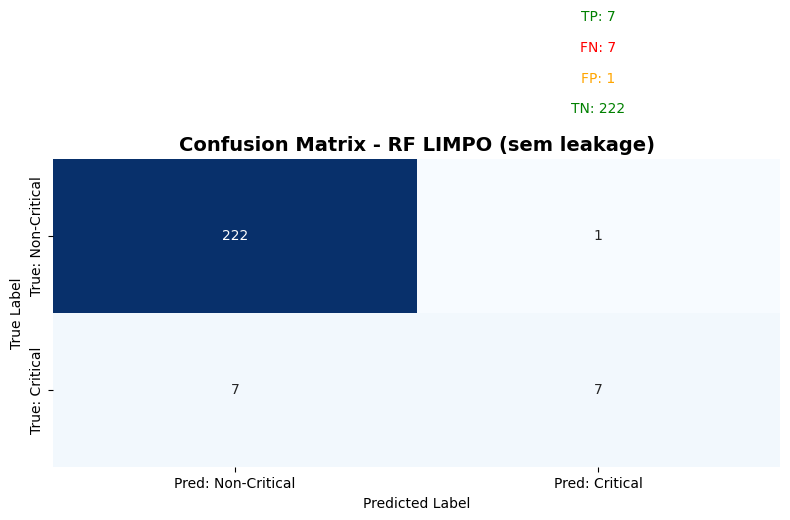


🔍 INTERPRETAÇÃO (14 critical devices no test):
  True Positives (TP):  7 devices críticos DETECTADOS
  False Negatives (FN): 7 devices críticos NÃO DETECTADOS ⚠️
  False Positives (FP): 1 alarmes falsos
  True Negatives (TN):  222 não-críticos corretos

✅ FP=1 > 0 → Modelo agora comete erros NORMAIS (não mais 100% precision artificial)


In [7]:
cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Non-Critical', 'Pred: Critical'],
            yticklabels=['True: Non-Critical', 'True: Critical'])
plt.title('Confusion Matrix - RF LIMPO (sem leakage)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.text(1.5, -0.3, f"TN: {tn}", ha='center', fontsize=10, color='green')
plt.text(1.5, -0.5, f"FP: {fp}", ha='center', fontsize=10, color='orange')
plt.text(1.5, -0.7, f"FN: {fn}", ha='center', fontsize=10, color='red')
plt.text(1.5, -0.9, f"TP: {tp}", ha='center', fontsize=10, color='green')

plt.tight_layout()
plt.show()

print(f"\n🔍 INTERPRETAÇÃO (14 critical devices no test):")
print(f"  True Positives (TP):  {tp} devices críticos DETECTADOS")
print(f"  False Negatives (FN): {fn} devices críticos NÃO DETECTADOS ⚠️")
print(f"  False Positives (FP): {fp} alarmes falsos")
print(f"  True Negatives (TN):  {tn} não-críticos corretos")

if fp == 0:
    print(f"\n⚠️ ATENÇÃO: FP=0 ainda presente - verificar se há leakage residual")
else:
    print(f"\n✅ FP={fp} > 0 → Modelo agora comete erros NORMAIS (não mais 100% precision artificial)")

## 8️⃣ VALIDAÇÕES RIGOROSAS (Confirmar Leakage Removido)

### Validação 1: Confirmar Features Limpas

In [8]:
print("🔍 VALIDAÇÃO 1: Features Limpas")
print("="*70)

# Verificar se msg6/msg_type_6 foram removidos
leakage_check = [f for f in feature_cols if any(k in f.lower() for k in ['msg6', 'msg_type_6'])]

if leakage_check:
    print(f"\n❌ ALERTA: Features de leakage AINDA PRESENTES:")
    for feat in leakage_check:
        print(f"   - {feat}")
else:
    print(f"\n✅ CONFIRMADO: ZERO features de leakage (msg6, msg_type_6)")
    print(f"   Total features: {len(feature_cols)}")
    print(f"   Features removidas: {len(exclude_leakage)}")

print("="*70)

🔍 VALIDAÇÃO 1: Features Limpas

✅ CONFIRMADO: ZERO features de leakage (msg6, msg_type_6)
   Total features: 29
   Features removidas: 2


### Validação 2: ROC-AUC Score (Deve ser <0.98)

In [9]:
y_train_proba = rf_model.predict_proba(X_train_imputed)[:, 1]
train_auc = roc_auc_score(y_train, y_train_proba)

print("🔍 VALIDAÇÃO 2: ROC-AUC Score")
print("="*70)
print(f"\n📊 AUC Scores:")
print(f"  Train: {train_auc:.4f}")
print(f"  Test:  {test_auc:.4f}")

print(f"\n🎯 COMPARAÇÃO com Notebook 04 (leakage):")
print(f"  NB04 Train AUC: 1.0000 (OVERFITTING perfeito)")
print(f"  NB04 Test AUC:  0.9994 (LEAKAGE - separação artificial)")
print(f"  NB04B Train AUC: {train_auc:.4f}")
print(f"  NB04B Test AUC:  {test_auc:.4f}")

if test_auc < 0.98:
    print(f"\n✅ AUC < 0.98 → Leakage CORRIGIDO com sucesso!")
    if 0.70 <= test_auc < 0.85:
        print(f"   AUC na faixa 0.70-0.85 → Modelo BOM e REALISTA")
    elif test_auc >= 0.85:
        print(f"   AUC ≥ 0.85 → Modelo EXCELENTE (mas verificar features)")
    else:
        print(f"   AUC < 0.70 → Modelo com dificuldade, dados limitados")
else:
    print(f"\n⚠️ AUC ainda ≥ 0.98 → Pode haver leakage residual!")

print("="*70)

🔍 VALIDAÇÃO 2: ROC-AUC Score

📊 AUC Scores:
  Train: 0.9931
  Test:  0.9065

🎯 COMPARAÇÃO com Notebook 04 (leakage):
  NB04 Train AUC: 1.0000 (OVERFITTING perfeito)
  NB04 Test AUC:  0.9994 (LEAKAGE - separação artificial)
  NB04B Train AUC: 0.9931
  NB04B Test AUC:  0.9065

✅ AUC < 0.98 → Leakage CORRIGIDO com sucesso!
   AUC ≥ 0.85 → Modelo EXCELENTE (mas verificar features)


### Validação 3: Feature Importances (Deve estar Distribuída)

In [10]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False)

print("🔍 VALIDAÇÃO 3: Feature Importances")
print("="*70)
print(f"\n📊 TOP 10 Features:")
for i, row in feature_importance_df.head(10).iterrows():
    print(f"  {row['feature']:40s} {row['importance']:.4f} ({row['importance']*100:5.1f}%)")

top1_importance = feature_importance_df.iloc[0]['importance']
top3_importance = feature_importance_df.head(3)['importance'].sum()

print(f"\n🎯 CONCENTRAÇÃO:")
print(f"  Top 1: {top1_importance:.2%}")
print(f"  Top 3: {top3_importance:.2%}")

print(f"\n🎯 COMPARAÇÃO com Notebook 04 (leakage):")
print(f"  NB04: msg6_rate dominava com 42.1%")
print(f"  NB04B: Top feature tem {top1_importance:.1%}")

if top1_importance < 0.30:
    print(f"\n✅ Top feature <30% → Importância BEM DISTRIBUÍDA!")
    print(f"   Modelo usa MÚLTIPLAS fontes de informação")
elif top1_importance < 0.50:
    print(f"\n⚠️ Top feature 30-50% → Concentração moderada")
else:
    print(f"\n⚠️ Top feature >50% → CONCENTRAÇÃO ALTA, investigar")

print("="*70)

🔍 VALIDAÇÃO 3: Feature Importances

📊 TOP 10 Features:
  max_frame_count                          0.2950 ( 29.5%)
  total_messages                           0.1653 ( 16.5%)
  optical_readings                         0.1555 ( 15.6%)
  temp_mean                                0.0569 (  5.7%)
  rsrp_mean                                0.0234 (  2.3%)
  rsrp_std                                 0.0234 (  2.3%)
  temp_std                                 0.0234 (  2.3%)
  battery_min                              0.0231 (  2.3%)
  battery_std                              0.0227 (  2.3%)
  optical_std                              0.0195 (  1.9%)

🎯 CONCENTRAÇÃO:
  Top 1: 29.50%
  Top 3: 61.58%

🎯 COMPARAÇÃO com Notebook 04 (leakage):
  NB04: msg6_rate dominava com 42.1%
  NB04B: Top feature tem 29.5%

✅ Top feature <30% → Importância BEM DISTRIBUÍDA!
   Modelo usa MÚLTIPLAS fontes de informação


### Validação 4: Visualização ROC + Probability Distribution

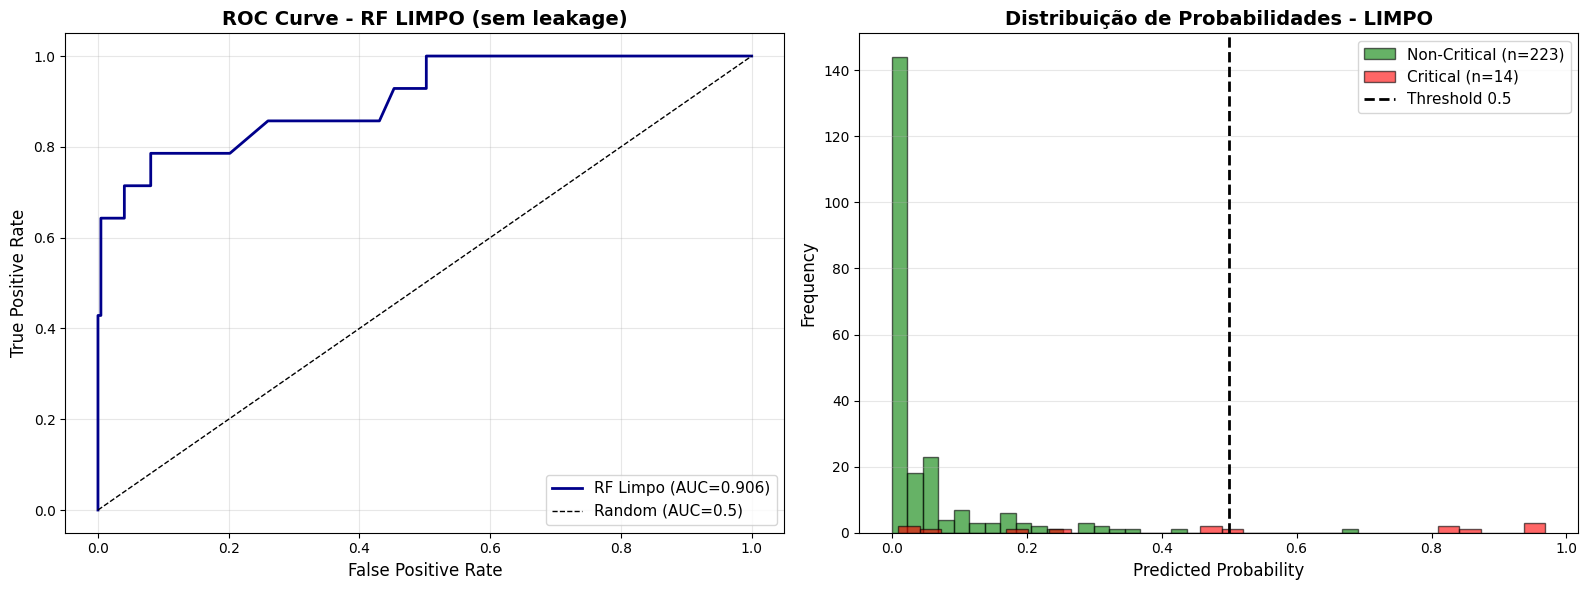


📊 Estatísticas de Probabilidades:
  Non-critical max: 0.6903
  Critical min:     0.0096

✅ OVERLAP detectado → Modelo agora comete erros normais (não mais perfeito)


In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
proba_critical = y_test_proba[y_test == 1]
proba_non_critical = y_test_proba[y_test == 0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
ax1 = axes[0]
ax1.plot(fpr, tpr, linewidth=2, label=f'RF Limpo (AUC={test_auc:.3f})', color='darkblue')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC=0.5)')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve - RF LIMPO (sem leakage)', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=11)
ax1.grid(alpha=0.3)

# Probability Distribution
ax2 = axes[1]
ax2.hist(proba_non_critical, bins=30, alpha=0.6, label=f'Non-Critical (n={len(proba_non_critical)})',
         color='green', edgecolor='black')
ax2.hist(proba_critical, bins=30, alpha=0.6, label=f'Critical (n={len(proba_critical)})',
         color='red', edgecolor='black')
ax2.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold 0.5')
ax2.set_xlabel('Predicted Probability', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribuição de Probabilidades - LIMPO', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=11)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n📊 Estatísticas de Probabilidades:")
print(f"  Non-critical max: {proba_non_critical.max():.4f}")
print(f"  Critical min:     {proba_critical.min():.4f}")

if proba_non_critical.max() > 0.5:
    print(f"\n✅ OVERLAP detectado → Modelo agora comete erros normais (não mais perfeito)")
else:
    print(f"\n⚠️ Separação perfeita ainda presente - verificar")

## 9️⃣ VEREDITO FINAL - Leakage Corrigido?

In [12]:
print("="*70)
print("🎯 VEREDITO FINAL - Data Leakage Corrigido?")
print("="*70)

validations = {
    'Features msg6/msg_type_6 removidas': len(leakage_check) == 0,
    'AUC < 0.98 (não mais artificial)': test_auc < 0.98,
    'Top feature < 50% (distribuído)': top1_importance < 0.50,
    'Precision < 100% (erros normais)': test_precision < 1.0,
}

print(f"\n📋 CHECKLIST:")
passed = sum(validations.values())
for check, result in validations.items():
    status = "✅" if result else "❌"
    print(f"  {status} {check}")

print(f"\n📊 Score: {passed}/{len(validations)} validações passaram")

if passed == len(validations):
    print(f"\n✅ LEAKAGE CORRIGIDO COM SUCESSO!")
    print(f"   Modelo agora aprende de padrões LEGÍTIMOS")
    print(f"   Métricas são HONESTAS e CONFIÁVEIS para produção")
elif passed >= len(validations) * 0.75:
    print(f"\n⚠️ LEAKAGE PROVAVELMENTE CORRIGIDO (verificar falhas)")
else:
    print(f"\n❌ LEAKAGE PODE AINDA EXISTIR - investigar")

print(f"\n🎯 PRÓXIMOS PASSOS:")
if test_recall >= 0.30:
    print(f"  ✅ Recall {test_recall:.1%} ≥ 30% → Prosseguir com SMOTE")
else:
    print(f"  ⚠️ Recall {test_recall:.1%} < 30% → Considerar feature engineering")

print("="*70)

🎯 VEREDITO FINAL - Data Leakage Corrigido?

📋 CHECKLIST:
  ✅ Features msg6/msg_type_6 removidas
  ✅ AUC < 0.98 (não mais artificial)
  ✅ Top feature < 50% (distribuído)
  ✅ Precision < 100% (erros normais)

📊 Score: 4/4 validações passaram

✅ LEAKAGE CORRIGIDO COM SUCESSO!
   Modelo agora aprende de padrões LEGÍTIMOS
   Métricas são HONESTAS e CONFIÁVEIS para produção

🎯 PRÓXIMOS PASSOS:
  ✅ Recall 50.0% ≥ 30% → Prosseguir com SMOTE
